Created a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$ and $\sigma$ values e.g. $m=256$ and $\sigma \in \{1, 10, 100\}$.

Source: https://bmild.github.io/fourfeat/ 
This problem statement is inspired by and built off of the authors' demo. 

### Imports

In [4]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np


from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  

## Helper Functions

### Experiment Runner (Fill in TODOs)

In [5]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):
    
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))
    
    
    # For each epoch...
    for epoch in tqdm(range(epochs)):
        # Shuffle the dataset
        # TODO implement this
        idx = np.random.permutation(len(X_train))
        X_train_shuffled, y_train_shuffled = X_train[idx], y_train[idx]
      
        # Training
        # Run the forward pass of the model to get a prediction and record the psnr
        # TODO implement this
        preds = net.forward(X_train_shuffled)
        train_psnr[epoch] = psnr(y_train_shuffled, preds)
        
        # Run the backward pass of the model to compute the loss, record the loss, and update the weights
        # TODO implement this
        loss = net.backward(y_train_shuffled)
        train_loss[epoch] = loss
        
        net.update(lr = learning_rate, opt = opt)
        #learning_rate*=0.95
        # Testing
        # No need to run the backward pass here, just run the forward pass to compute and record the psnr
        # TODO implement this
        test_preds = net.forward(X_test)
        test_psnr[epoch] = psnr(y_test, test_preds)
        predicted_images[epoch] = test_preds
        
        
    return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings (Fill in TODOs)

In [6]:
# Data loader - already done for you
def get_image(size=512, \
              image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):
    # Download image, take a square crop from the center  
    img = imageio.imread(image_url)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 256
    img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

    if size != 512:
        img = cv2.resize(img, (size, size))

    plt.imshow(img)
    plt.show()
    
    
    # Create input pixel coordinates in the unit square
    coords = np.linspace(0, 1, img.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    test_data = [x_test, img]
    train_data = [x_test[::2, ::2], img[::2, ::2]]

    return train_data, test_data

In [7]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict(m):
    B_dict = {}
    B_dict['none'] = None
    
    B_dict['basic'] = np.identity(2)
    B_dict['gauss_1'] = np.random.normal(0, 1, m*2).reshape(m,2)
    B_dict['gauss_10'] = np.random.normal(0, 10, m*2).reshape(m,2)
    B_dict['gauss_100'] = np.random.normal(0, 100, m*2).reshape(m,2)

    return B_dict

In [8]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
    if B is None:
        # "none" mapping - just returns the original input coordinates
        return x
    else:
        return np.concatenate([np.cos((2*np.pi*x) @ B.T), np.sin((2*np.pi*x) @ B.T)], axis=-1)
    # "basic" mapping and "gauss_X" mappings project input features using B
    
        pass

In [9]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(B_dict, mapping):
    # mapping is the key to the B_dict, which has the value of B
    # B is then used with the function `input_mapping` to map x  
    output_size = 3
    y_train = train_data[1].reshape(-1, output_size)
    y_test = test_data[1].reshape(-1, output_size)
    X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
    X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
    return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

In [10]:
def mse(y, p):
  
  # make sure it is consistent with your implementation in neural_net.py
    return np.sum((y-p)**2/len(y))
    pass

def psnr(y, p):
    
    return 20 * np.log10(255.0 / (np.sqrt(mse(y, p))))
    pass

### Plotting

In [11]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
  # plot the training loss
  plt.subplot(2, 1, 1)
  plt.plot(train_loss)
  plt.title('MSE history')
  plt.xlabel('Iteration')
  plt.ylabel('MSE Loss')

  # plot the training and testing psnr
  plt.subplot(2, 1, 2)
  plt.plot(train_psnr, label='train')
  plt.plot(test_psnr, label='test')
  plt.title('PSNR history')
  plt.xlabel('Iteration')
  plt.ylabel('PSNR')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [12]:
def plot_reconstruction(p, y):
  p_im = p.reshape(size,size,3)
  y_im = y.reshape(size,size,3)

  plt.figure(figsize=(12,6))

  # plot the reconstruction of the image
  plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

  # plot the ground truth image
  plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

  print("Final Test MSE", mse(y, p))
  print("Final Test psnr",psnr(y, p))

In [13]:
def plot_reconstruction_progress(predicted_images, y, N=8):
  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N+1, i+1)
      plt.imshow(predicted_images[j].reshape(size,size,3))
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y.reshape(size,size,3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

In [14]:
def plot_feature_mapping_comparison(outputs, gt):
  # plot reconstruction images for each mapping
  plt.figure(figsize=(24, 4))
  N = len(outputs)
  for i, k in enumerate(outputs):
      plt.subplot(1, N+1, i+1)
      plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
      plt.title(k)
  plt.subplot(1, N+1, N+1)
  plt.imshow(gt)
  plt.title('GT')
  plt.show()

  # plot train/test error curves for each mapping
  iters = len(outputs[k]['train_psnrs'])
  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
  plt.title('Train error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.subplot(122)
  for i, k in enumerate(outputs):
      plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
  plt.title('Test error')
  plt.ylabel('PSNR')
  plt.xlabel('Training iter')
  plt.legend()
  plt.show()

# Low Resolution Reconstruction

C:\Users\aksha\AppData\Local\Temp\ipykernel_21776\2962548933.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


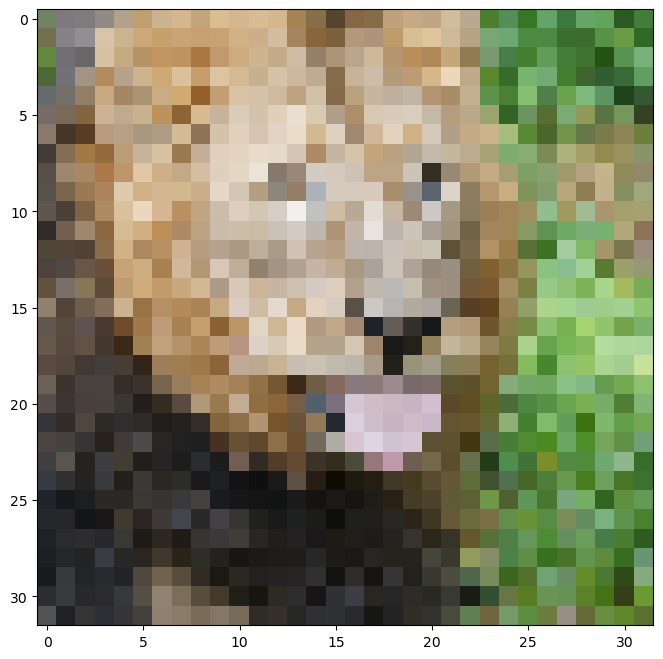

In [46]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

  0%|          | 0/100 [00:00<?, ?it/s]

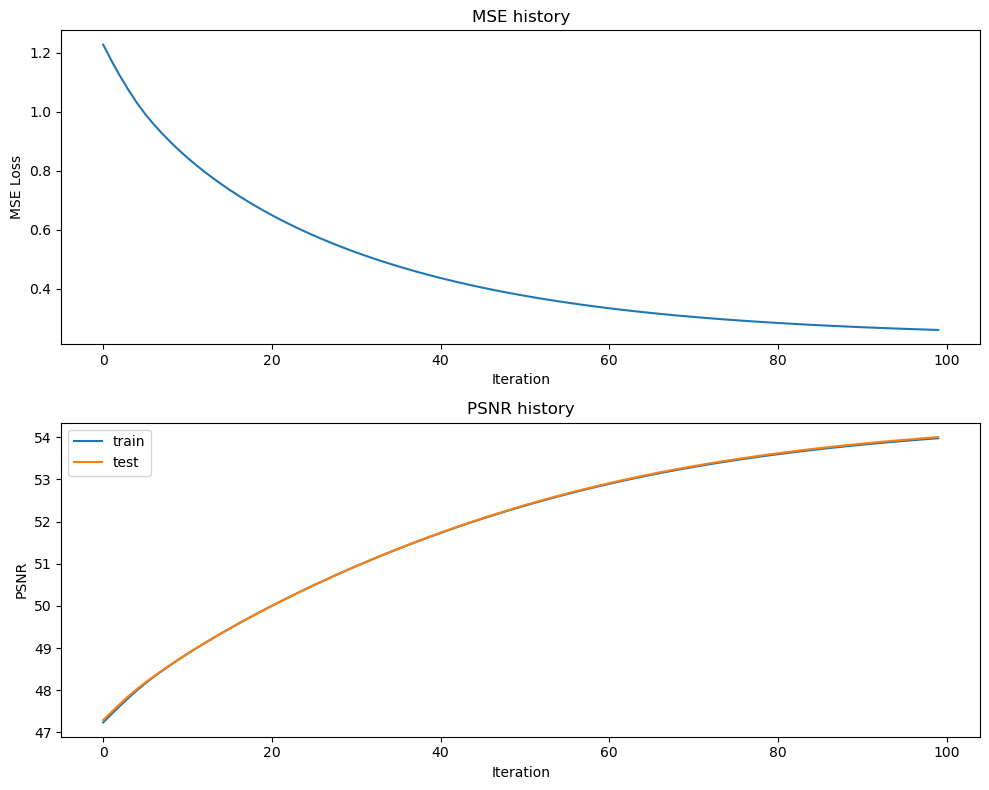

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Final Test MSE 0.25854057862418367
Final Test psnr 54.005516444263435


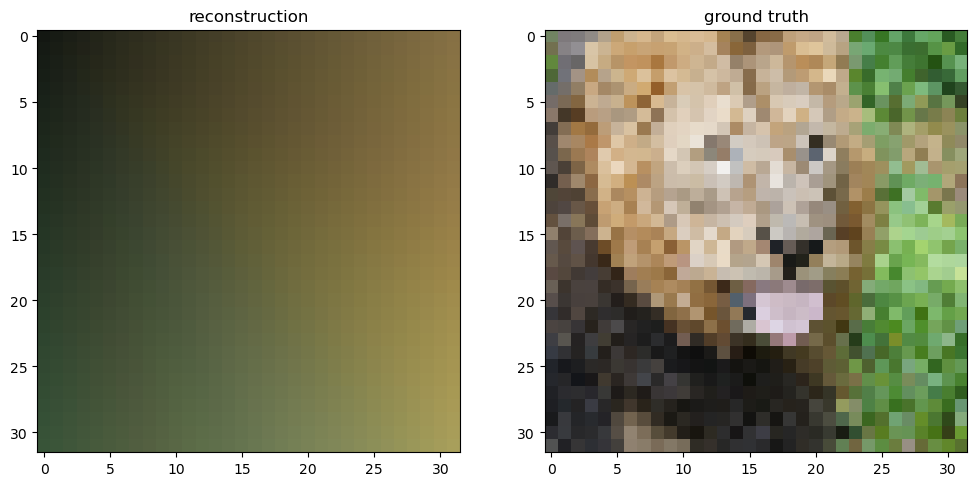

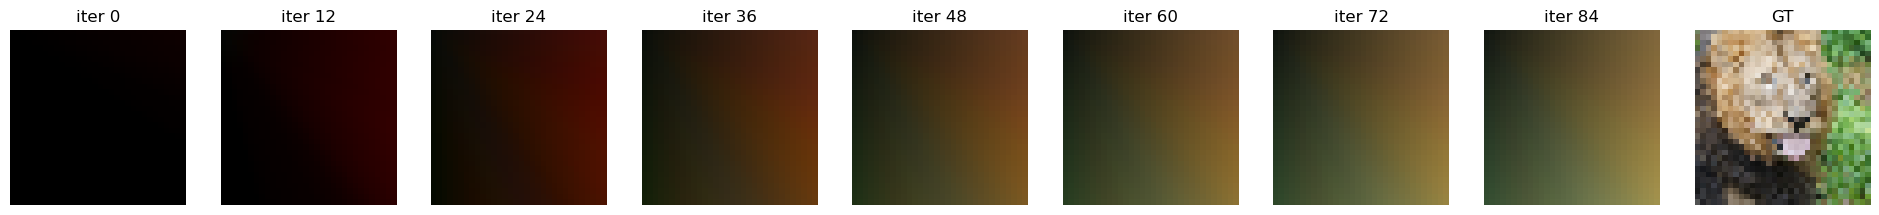

In [47]:
# get input features
B_dict = get_B_dict(256)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

input_size = X_train.shape[1]
num_layers = 5
hidden_size = 4
hidden_sizes = [256, 256, 256, 256]
output_size = 3
epochs = 100
learning_rate = 0.001
opt = "SGD"

# run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

  0%|          | 0/150 [00:00<?, ?it/s]

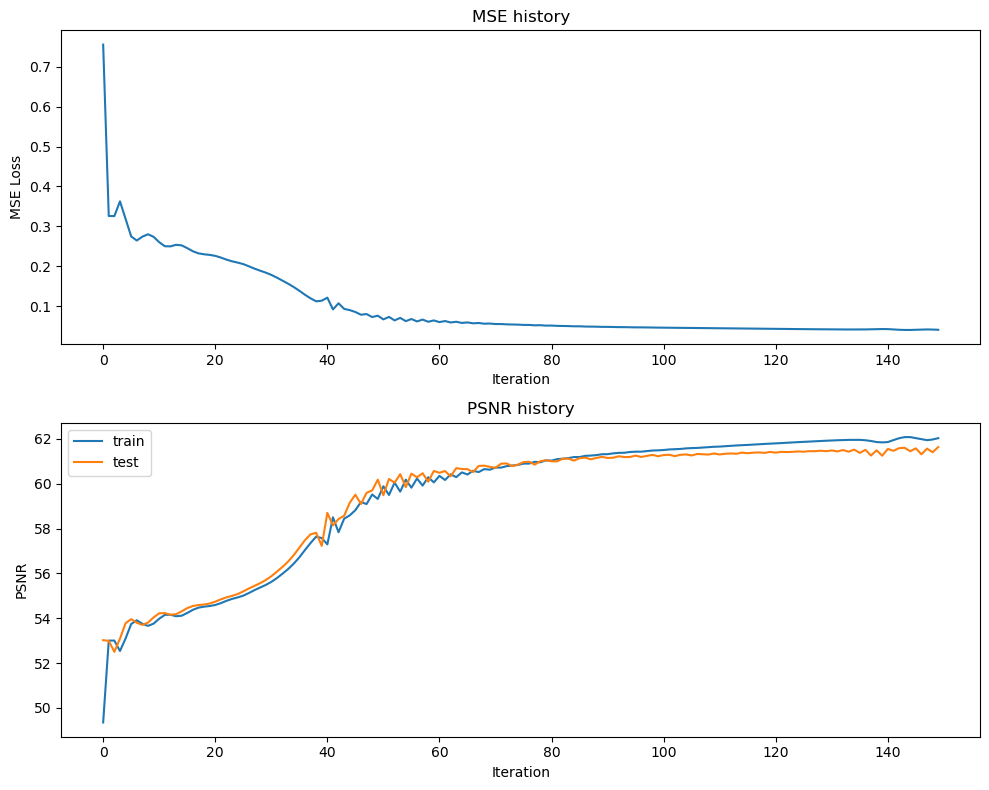

Final Test MSE 0.0446045423174086
Final Test psnr 61.6370127339037


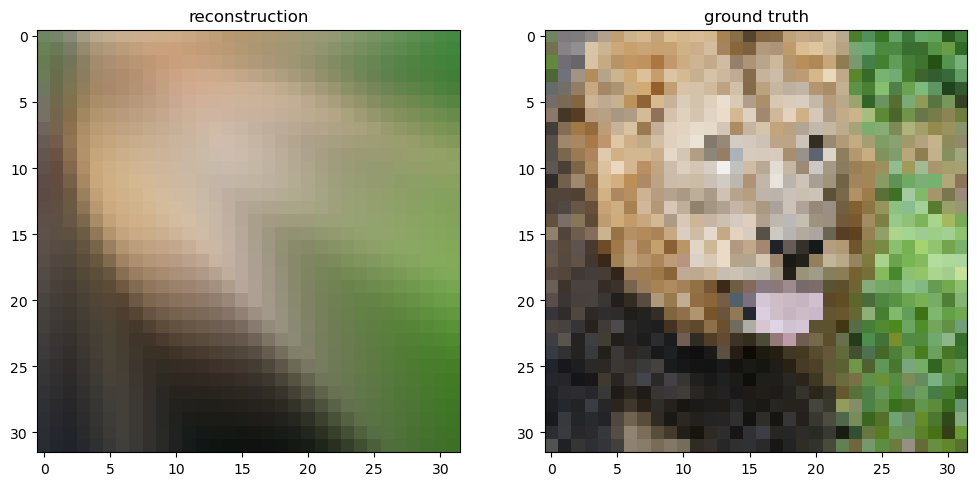

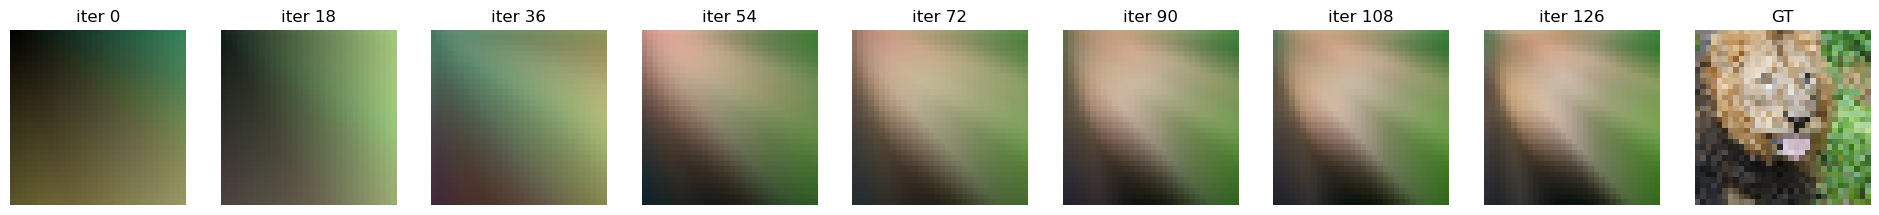

In [48]:
# get input features
B_dict = get_B_dict(256)
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

input_size = X_train.shape[1]
num_layers = 5
hidden_size = 4
hidden_sizes = [256, 256, 256, 256]
output_size = 3
epochs = 150
learning_rate = 0.001
opt = "Adam"

# run NN experiment on input features
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt)

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [65]:
def train_wrapper(mapping, size, opt='Adam'):
    
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)
    input_size = X_train.shape[1]
    num_layers = 5
    hidden_size = 4
    hidden_sizes = [256, 256, 256, 256]
    output_size = 3
    epochs = 200
    learning_rate = 0.001
    print(opt)
    net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt)
    
    return {
        'net': net, 
        'train_psnrs': train_psnrs, 
        'test_psnrs': test_psnrs,
        'train_loss': train_loss,
        'pred_imgs': predicted_images}



In [60]:
B_dict = get_B_dict(256)
B_dict.keys()

dict_keys(['none', 'basic', 'gauss_1', 'gauss_10', 'gauss_100'])

In [61]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size, opt="SGD")

  0%|          | 0/5 [00:00<?, ?it/s]

training none
SGD


  0%|          | 0/500 [00:00<?, ?it/s]

training basic
SGD


  0%|          | 0/500 [00:00<?, ?it/s]

training gauss_1
SGD


  0%|          | 0/500 [00:00<?, ?it/s]

training gauss_10
SGD


  0%|          | 0/500 [00:00<?, ?it/s]

training gauss_100
SGD


  0%|          | 0/500 [00:00<?, ?it/s]

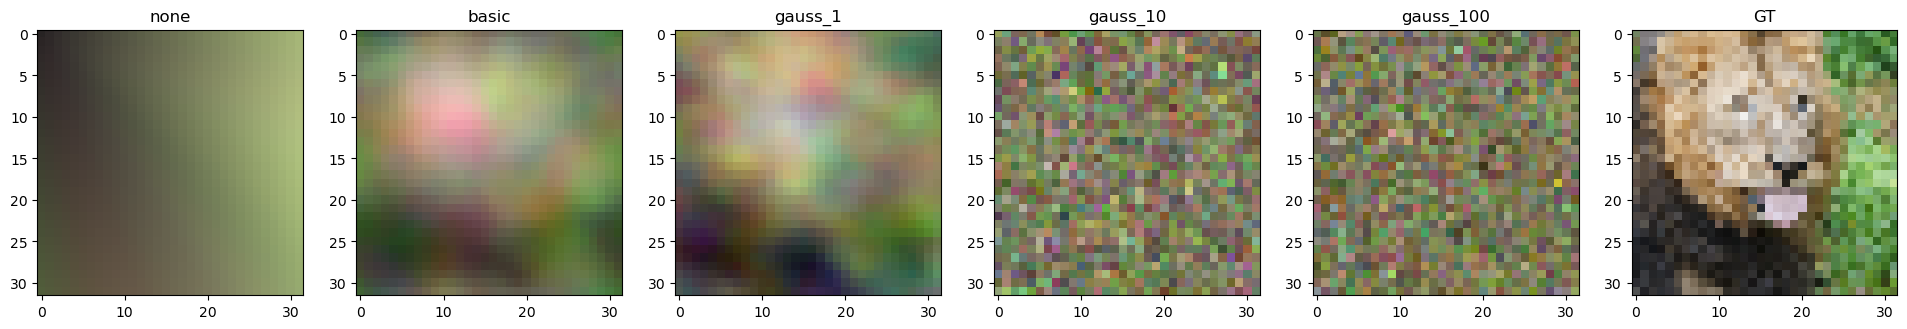

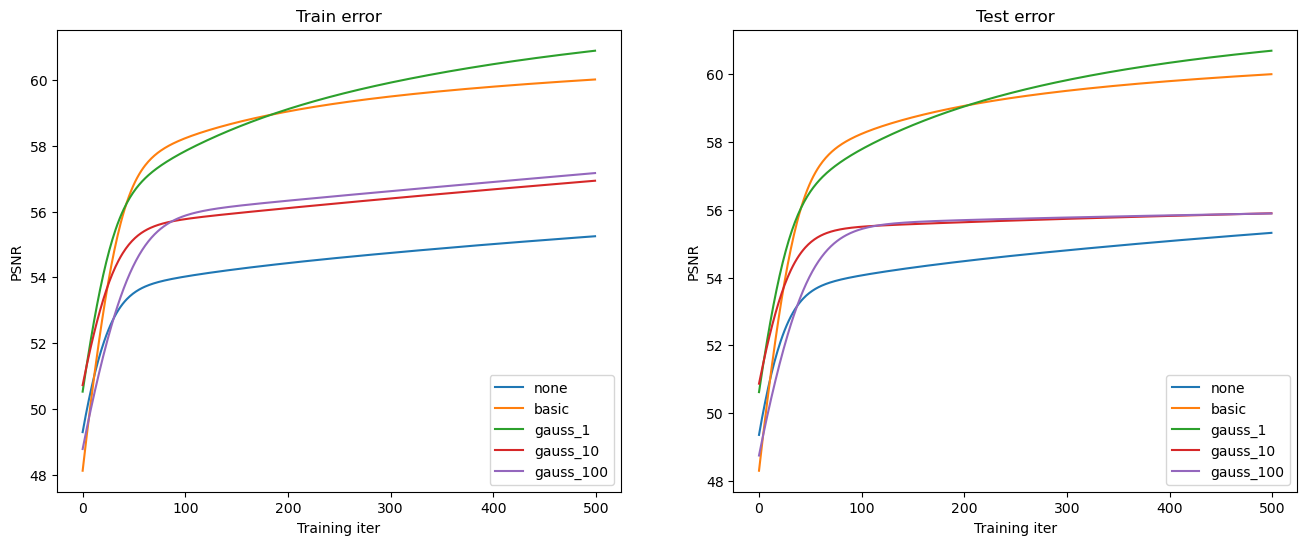

In [63]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

C:\Users\aksha\AppData\Local\Temp\ipykernel_21776\2962548933.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


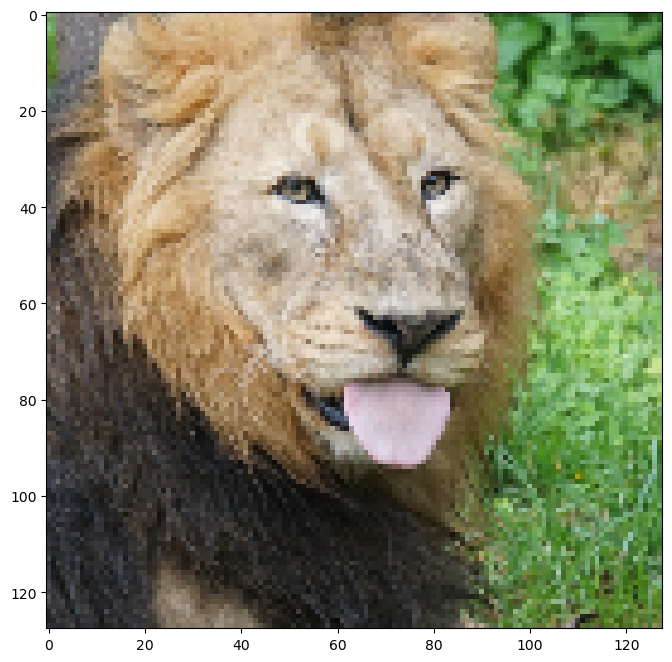

In [77]:
size = 128
train_data, test_data = get_image(size)

In [86]:
def train_wrapper(mapping, size, opt='Adam'):
    
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)
    input_size = X_train.shape[1]
    num_layers = 5
    hidden_size = 4
    hidden_sizes = [256, 256, 256, 256]
    output_size = 3
    epochs = 200
    learning_rate = 0.001
    print(opt)
    net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt)
    
    return {
        'net': net, 
        'train_psnrs': train_psnrs, 
        'test_psnrs': test_psnrs,
        'train_loss': train_loss,
        'pred_imgs': predicted_images}

In [ ]:
size = 128
train_data, test_data = get_image(size)

In [88]:
B_dict = get_B_dict(256)

In [89]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size,'Adam')

  0%|          | 0/5 [00:00<?, ?it/s]

training none
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training basic
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_1
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_10
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_100
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


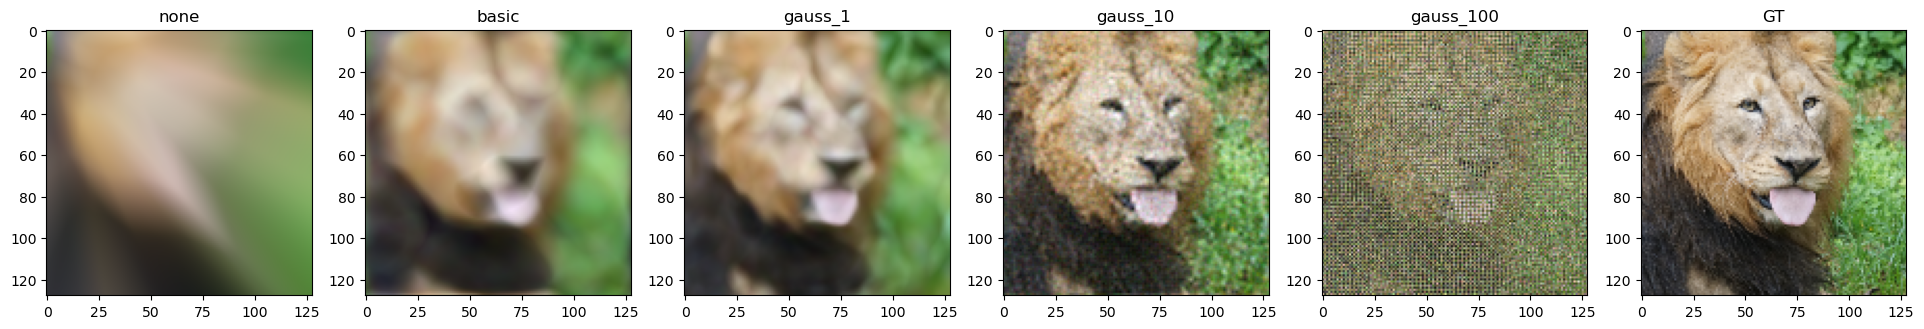

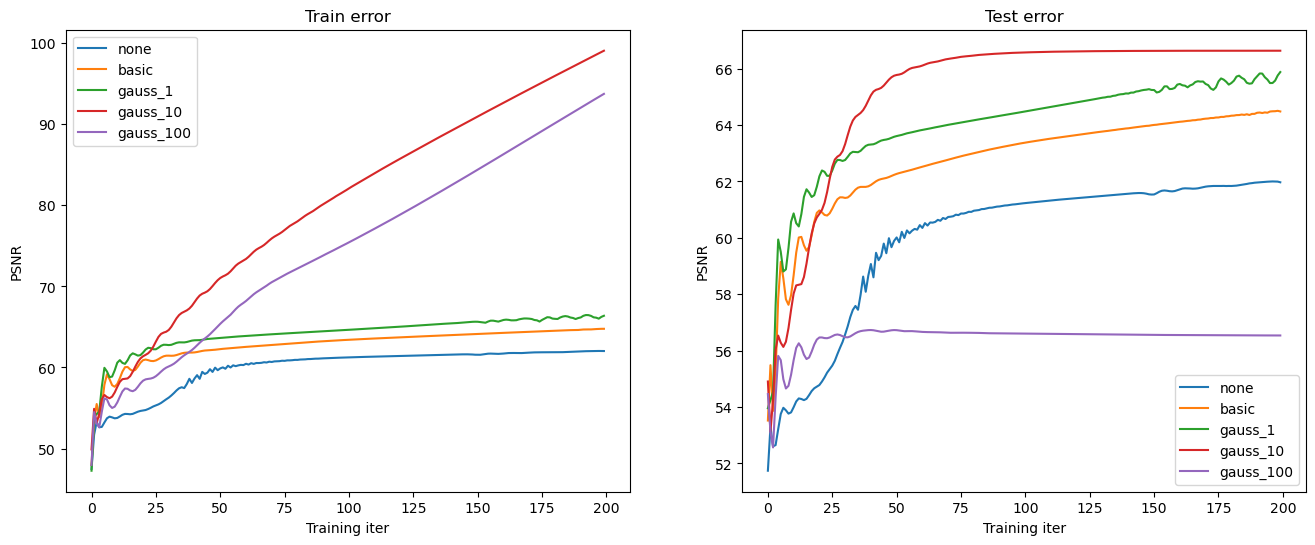

In [90]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

C:\Users\aksha\AppData\Local\Temp\ipykernel_19416\2962548933.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


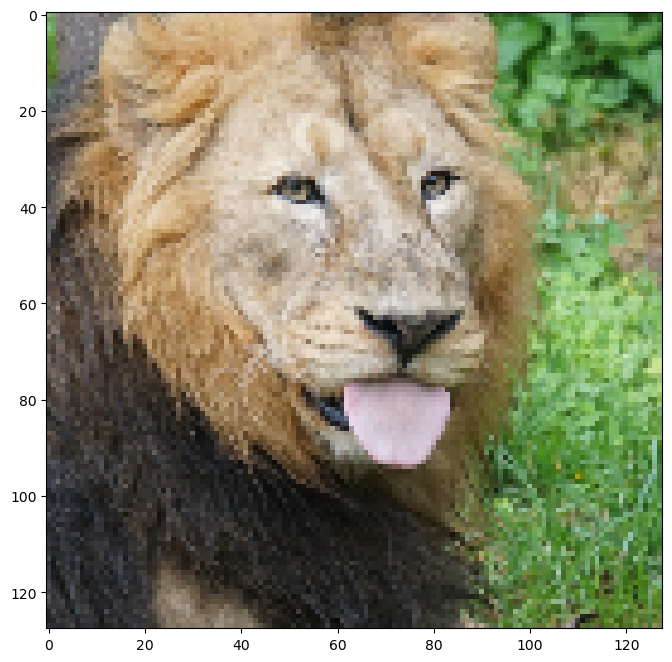

In [19]:
size = 128
train_data, test_data = get_image(size)

In [20]:
B_dict = get_B_dict(256)

In [35]:
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

In [38]:
def train_wrapper(mapping, size, opt='Adam'):
    
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)
    input_size = X_train.shape[1]
    num_layers = 5
    hidden_size = 4
    hidden_sizes = [256, 256, 256, 256]
    output_size = 3
    epochs = 200
    learning_rate = 0.001
    print(opt)
    net, train_psnrs, test_psnrs, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt)
    
    return {
        'net': net, 
        'train_psnrs': train_psnrs, 
        'test_psnrs': test_psnrs,
        'train_loss': train_loss,
        'pred_imgs': predicted_images}

In [39]:
outputs = {}
for k in tqdm(B_dict):
  print("training", k)
  outputs[k] = train_wrapper(k, size,'Adam')

  0%|          | 0/5 [00:00<?, ?it/s]

training none
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training basic
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_1
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_10
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

training gauss_100
Adam


  0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


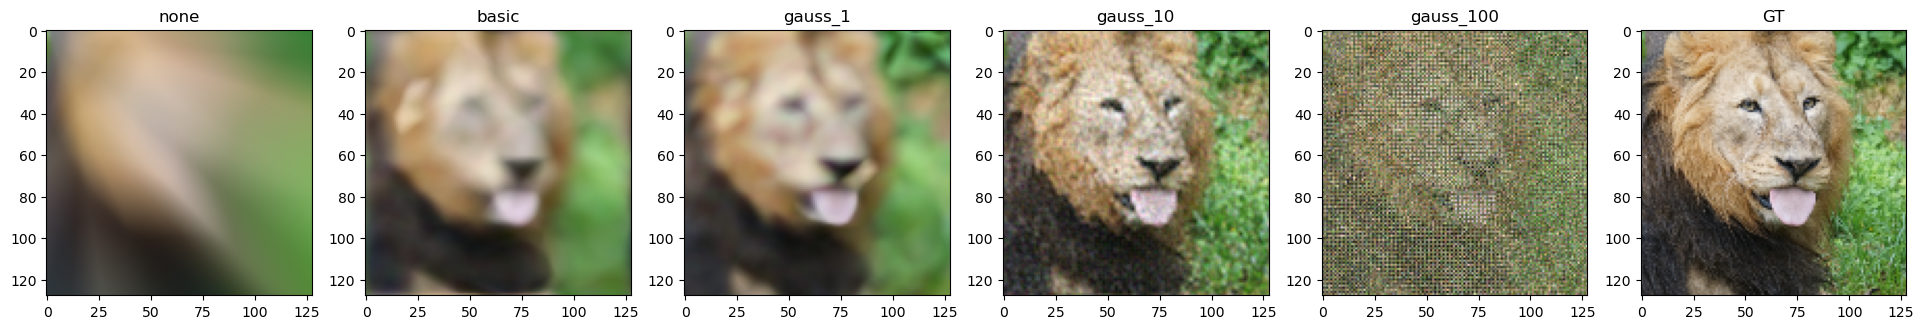

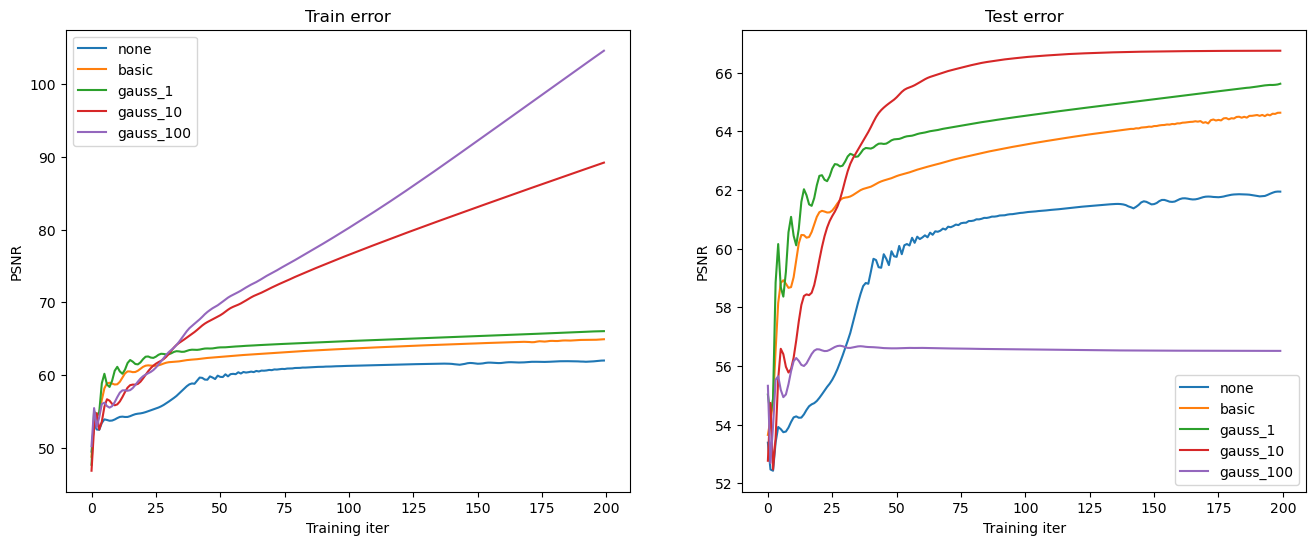

In [40]:
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [42]:
epochs=200
size=128

In [43]:
# Save out video

def create_and_visualize_video(outputs, size=size, epochs=epochs, filename='training_convergence.mp4'):
  all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
  data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
  f = os.path.join(filename)
  imageio.mimwrite(f, data8, fps=20)

  # Display video inline
  from IPython.display import HTML
  from base64 import b64encode
  mp4 = open(f, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

  N = len(outputs)
  if N == 1:
    return HTML(f'''
    <video width=256 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    ''')
  else:
    return HTML(f'''
    <video width=1000 controls autoplay loop>
          <source src="{data_url}" type="video/mp4">
    </video>
    <table width="1000" cellspacing="0" cellpadding="0">
      <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
      <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
    </table>
    '''.format(*list(outputs.keys())))

In [158]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

     --------------------------------------- 22.6/22.6 MB 28.5 MB/s eta 0:00:00


In [44]:
# multi video example
create_and_visualize_video(outputs, epochs=epochs, size=128)

,,,,
none,basic,gauss_1,gauss_10,gauss_100


In [159]:
predicted_images.shape

(150, 102400, 3)